In [30]:
import torch 
import torchvision
import timm

model = timm.create_model('vit_small_patch16_224',num_classes = 0, pretrained=True)
model_2 =  torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained = False)
# model_3 = torchvision.models.vit_b_16() # more complicated

Using cache found in C:\Users\sarth/.cache\torch\hub\facebookresearch_dino_main


In [31]:
for p in model.parameters():
    p.requires_grad = False
for p in range(len(model.blocks)):
    for param in model.blocks[p].attn.qkv.parameters():
        param.requires_grad = True

In [33]:
for p in model.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False


In [3]:
trial = torch.nn.Sequential(
    torch.nn.Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16)), 
    torch.nn.Flatten(-2,-1)
)
norm_layer = torch.nn.LayerNorm((768,), eps=1e-06, elementwise_affine=True)
norm_layer(trial(torch.randn(1,3,224,224)).permute(0,2,1)).shape

torch.Size([1, 196, 768])

### DINO Attention (Visualize_attention.py)

In [13]:
x = model_2.get_last_selfattention(torch.randn(1,3,224,224))
# print(x.shape)
# x = x[0,:,0,1:]
# x.shape

### Getting attention maps patchwise from the model

In [36]:
feats = {}
def hook(module, input, output):
    input = input[0]
    B, N, C = input.shape
    qkv = module.qkv(input).reshape(B, N, 3, module.num_heads, C // module.num_heads).permute(2, 0, 3, 1, 4)
    print(module.qkv(input).shape)
    print(qkv.shape)
    print(output.shape)
    feats['q'] = qkv[0]
    feats['k'] = qkv[1]
    feats['v'] = qkv[2]

id = model.blocks[-1].attn.register_forward_hook(hook)
# id = model.patch_embed.register_forward_hook(hook)
_ = model(torch.randn(1,3,224,224))
id.remove()

torch.Size([1, 197, 2304])
torch.Size([3, 1, 12, 197, 64])
torch.Size([1, 197, 768])


In [7]:
for k,v in feats.items():
    print(v.shape)
q = feats['q']
k = feats['k']

scale = q.shape[-1] ** -0.5
attn = (q@k.transpose(-2, -1))*scale
attn = attn.softmax(dim=-1)
attn.shape

torch.Size([1, 12, 197, 64])
torch.Size([1, 12, 197, 64])
torch.Size([1, 12, 197, 64])


torch.Size([1, 12, 197, 197])

In [13]:
(attn@v).permute(0,2,1,3).flatten(2).shape

torch.Size([1, 197, 768])

### Can we use Jensen Shannon Divergence
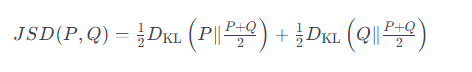
https://proceedings.neurips.cc/paper/2021/file/fe2d010308a6b3799a3d9c728ee74244-Paper.pdf


https://openaccess.thecvf.com/content_CVPR_2019/papers/Guo_Visual_Attention_Consistency_Under_Image_Transforms_for_Multi-Label_Image_Classification_CVPR_2019_paper.pdf

# Idea

Suppose we have an Image $x$ and we transform it using a function g to get and augmented image $g(x)$. Now after passing the inputs through the model we get the attention maps $A_1$ and $A_2$ 

Loss Function Concept: $g(A_1)$ and $A_2$ should be similar and hence compared 

For comparing the labels: weighted sigmoid cross entropy loss (used in the other paper)

KL Divergence or JS divergence -  we can global pool the features and apply divergence on them (Ask sir once)

Transformation: Translation, rotation, flipping, scalling

[1, 196, 768] will be the output from the attention layer where the second dimension corresponds to the patches. 

Since the divergence is computed on 2 distributions, 2 ideas:
- We use the Q,V between to get a 4D tensor and then compute the divergence between 2 images (assumption: the distribution of attention maps across different pixels should be the same)
- We get the output of the attention layer and then we perform some operations on it after that we compare this distribution over multiple images

In [14]:
import torch
from torch import nn

loss = nn.KLDivLoss()
x1 = torch.randn(1,1, 196*12, 196).softmax(dim = -1)
x2 = torch.randn(1,1, 196*12, 196).softmax(dim = -1)

print(f'KL Divergence: {loss(x1,x2)}')
print(f'JS Divergence: {0.5*loss(x1,(x1+x2)/2)+0.5*loss(x2,(x1+x2)/2)}')

KL Divergence: -0.024447957053780556
JS Divergence: -0.02549160271883011


In [33]:
from torch import nn

x = torch.randn([1, 8, 197, 197])
x = x[:,:,1:,1:].reshape(1,8,14,14,14,14)
y = []
for i in range(8):
    print(nn.AvgPool2d(14,14)(x[:,i].squeeze(1).reshape(1,196,14,14)).shape)
    y.append(nn.AvgPool2d(14,14)(x[:,i].squeeze(1).reshape(1,196,14,14)).squeeze(-1).squeeze(-1))

torch.cat(y, dim = 0).shape

torch.Size([1, 196, 1, 1])
torch.Size([1, 196, 1, 1])
torch.Size([1, 196, 1, 1])
torch.Size([1, 196, 1, 1])
torch.Size([1, 196, 1, 1])
torch.Size([1, 196, 1, 1])
torch.Size([1, 196, 1, 1])
torch.Size([1, 196, 1, 1])


torch.Size([8, 196])

In [59]:
x = torch.randn(1,196,768)
x = x.transpose(-2,-1)
print(x.shape)
x = x.reshape(x.shape[0], 768,14,14)
print(x.shape)
nn.AvgPool2d(8,8)(x).shape

torch.Size([1, 768, 196])
torch.Size([1, 768, 14, 14])


torch.Size([1, 768, 1, 1])

# Understanding Attention in ViT

In [8]:
inp = torch.randn(1,197,768)
num_heads = 8
head_dim = 768//num_heads
scale = head_dim ** -0.5
qkv = torch.nn.Linear(768, 768*3)
proj = torch.nn.Linear(768,768)

In [9]:
qkv(inp).shape

torch.Size([1, 197, 2304])

In [10]:
b,n,c = inp.shape
temp = qkv(inp).reshape(b,n,3,num_heads, head_dim).permute(2, 0, 3, 1, 4)
q,k,v = temp.unbind(0)
q.shape

torch.Size([1, 8, 197, 96])

In [12]:
attn = q@k.transpose(-2,-1)
attn = attn.softmax(dim = -1)
attn.shape, v.shape

(torch.Size([1, 8, 197, 197]), torch.Size([1, 8, 197, 96]))

In [13]:
(attn@v).transpose(1,2).reshape(b,n,c).shape

torch.Size([1, 197, 768])

In [59]:
b,n,c

(1, 197, 768)

# Understanding Attention in stable diffusion

### Linear Attention 
https://arxiv.org/ftp/arxiv/papers/2007/2007.14902.pdf

In [169]:
from torch import nn, einsum
from einops import rearrange, repeat
dim = in_channels = 64
heads=4 
dim_head=32
hidden_dim = dim_head * heads # 
to_qkv = torch.nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
to_out = torch.nn.Conv2d(hidden_dim, dim, 1)

inp = torch.randn(1,64,32,32)

In [185]:
b,c,h,w = inp.shape
qkv = to_qkv(inp)
q,k,v = rearrange(qkv, 'b (qkv heads c) h w -> qkv b heads c (h w)', heads = heads, qkv=3)
k = k.softmax(dim=-1)  
qkv.shape, q.shape, k.shape, v.shape

(torch.Size([1, 384, 32, 32]),
 torch.Size([1, 4, 32, 1024]),
 torch.Size([1, 4, 32, 1024]),
 torch.Size([1, 4, 32, 1024]))

In [186]:
context = torch.einsum('bhdn,bhen->bhde', k, v)
context.shape

torch.Size([1, 4, 32, 32])

In [187]:
((k@v.transpose(-2,-1)) == context).all()

tensor(True)

In [188]:
out = torch.einsum('bhde,bhdn->bhen', context, q)
out.shape

torch.Size([1, 4, 32, 1024])

In [196]:
((context.transpose(-1,-2)@q) == out).all()

tensor(True)

In [197]:
out = rearrange(out, 'b heads c (h w) -> b (heads c) h w', heads=heads, h=h, w=w)
out.shape

torch.Size([1, 128, 32, 32])

In [201]:
((context.transpose(-1,-2)@q).reshape(b,128, h, w) == out).all()

tensor(True)

### Spatial self attention

In [135]:
in_channels = 64
inp = torch.randn(1,64,32,32)

q_linear = torch.nn.Conv2d(in_channels, in_channels, kernel_size = 1, stride = 1, padding = 0)
k_linear = torch.nn.Conv2d(in_channels, in_channels, kernel_size = 1, stride = 1, padding = 0)
v_linear = torch.nn.Conv2d(in_channels, in_channels, kernel_size = 1, stride = 1, padding = 0)
proj_out = torch.nn.Conv2d(in_channels, in_channels, kernel_size = 1, stride = 1, padding = 0)

In [136]:
q = q_linear(inp);k = k_linear(inp);v = v_linear(inp)
q.shape, k.shape, v.shape

(torch.Size([1, 64, 32, 32]),
 torch.Size([1, 64, 32, 32]),
 torch.Size([1, 64, 32, 32]))

In [137]:
b,c,h,w = q.shape

q1 = rearrange(q, 'b c h w -> b (h w) c') # combining all the pixels in 2 the second dimension
k1 = rearrange(k, 'b c h w -> b (h w) c')
method_1 = q1@k1.transpose(-1,-2)
q1.shape, k1.shape

(torch.Size([1, 1024, 64]), torch.Size([1, 1024, 64]))

In [138]:
q2 = rearrange(q, 'b c h w -> b (h w) c') # combining all the pixels in 2 the second dimension
k2 = rearrange(k, 'b c h w -> b c (h w)')
method_2 = torch.einsum('bij,bjk->bik', q2, k2)
q2.shape, k2.shape

(torch.Size([1, 1024, 64]), torch.Size([1, 64, 1024]))

In [139]:
(method_1 == method_2).all()

tensor(True)

In [140]:
q = rearrange(q, 'b c h w -> b (h w) c') # combining all the pixels in 2 the second dimension
k = rearrange(k, 'b c h w -> b (h w) c')
v = rearrange(v, 'b c h w -> b (h w) c')
scale = int(c) ** -0.5 # scale is taken of the -1 dim
attn = q1@k1.transpose(-1,-2) * (scale)
attn = attn.softmax(dim = -1)

In [142]:
attn.shape, v.shape

(torch.Size([1, 1024, 1024]), torch.Size([1, 1024, 64]))

In [154]:
(attn@v) == torch.einsum('bij,bjk -> bki', v.transpose(-2,-1), attn.transpose(-2,-1))

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [False, False, False,  ..., False, False, False]]])

In [155]:
(attn@v) == torch.einsum('bij,bjk -> bik', attn, v)

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

In [158]:
x = attn@v
x.shape

torch.Size([1, 1024, 64])

In [160]:
x = rearrange(x, 'b (h w) c -> b c h w', h = h)
x.shape

torch.Size([1, 64, 32, 32])

In [161]:
proj_out(x).shape

torch.Size([1, 64, 32, 32])

In [210]:
rearrange(attn, 'b (h1 w1) (h2 w2) -> b h1 w1 h2 w2', h1=32, h2 = 32).shape

torch.Size([1, 32, 32, 32, 32])

In [211]:
proj_out(x).shape

torch.Size([1, 64, 32, 32])

### Checking of storing transforms

In [3]:
import albumentations as A
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
transform = A.Compose([
    A.HorizontalFlip(p=1),
])
transform2 = transforms.RandomHorizontalFlip(p=1)

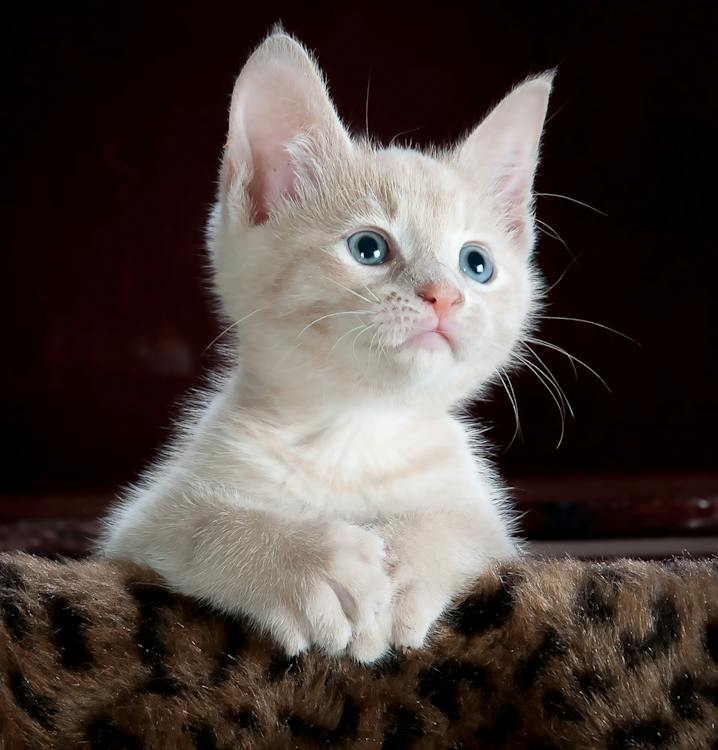

In [4]:
Image.open('cat.jpg')

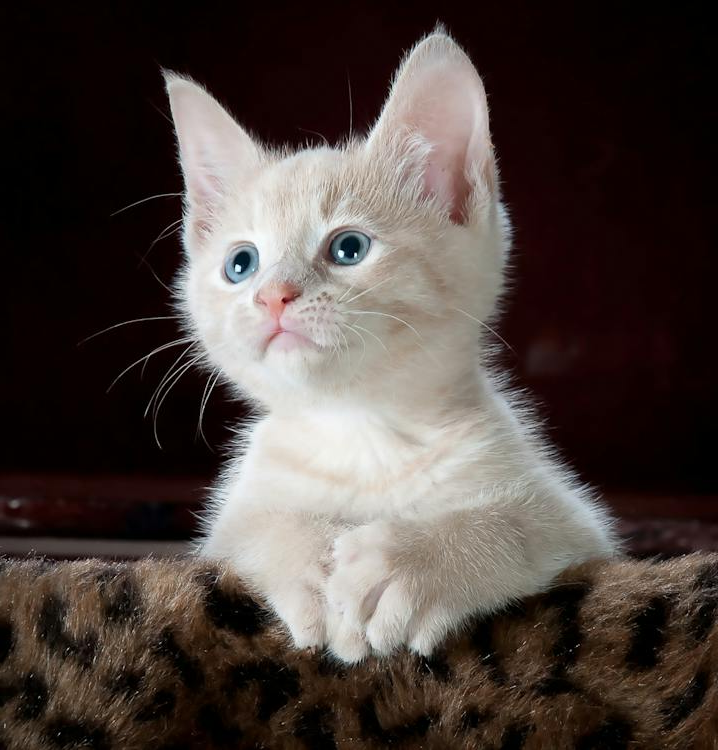

In [5]:
# Image.fromarray(transform(image = np.array(Image.open('cat.jpg')))['image'])
transform2(Image.open('cat.jpg'))

In [6]:
def flip(x):
    x1 = torch.zeros_like(x)
    for k in range(x.shape[-1]):
        x1[:,:,:,:,:,x.shape[-1] - 1 - k] = x[:,:,:,:,:,k]

    return x1

In [8]:
inp = torch.randn(8,12,14,14,14,14)

(transform2(inp) == flip(inp)).all()

tensor(True)

In [22]:
def horizontal_flip(x):
    x1 = torch.zeros_like(x)
    
    # for i in range(x.shape[1]):
    #     for j in range(x.shape[2]):
    #         x1[:,i,x.shape[2]-1-j,:,:] = x[:,i,j,:,:]
    #  for i in range(x.shape[3]):
    for j in range(x.shape[-1]):
        x1[:,:,:,:,x.shape[-1]-1-j] = x[:,:,:,:,j]

    return x1

In [14]:
from model import Model
import torch
model = Model()
items = model(torch.randn(8,3,224,224),torch.randn(8,3,224,224)) #assuming transformation is horizontal
for i in items:
    print(i.shape)

self_attn_1, output_1, self_attn_2, output_2 = items

torch.Size([8, 6, 196, 196])
torch.Size([8, 6, 14, 14, 14, 14])
torch.Size([8, 30])
torch.Size([8, 6, 14, 14, 14, 14])
torch.Size([8, 30])


In [15]:
model.parameters()
optim = torch.optim.Adam(model.parameters())
optim.zero_grad()
optim.step

<bound method Adam.step of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)>

In [16]:
from utils_own import horizontal_flip, vertical_flip, horizontal_flip_target, vertical_flip_target
from torchvision import transforms
# transform = transforms.RandomHorizontalFlip(p=1)
# transform2 = transforms.RandomVerticalFlip(p=1)

# (horizontal_flip(self_attn_1) == transform(self_attn_1)).all(), (vertical_flip(self_attn_1) == transform2(self_attn_1)).all()

self_attn_2 = horizontal_flip_target(horizontal_flip(self_attn_2))

In [7]:
loss = torch.nn.MSELoss()
loss(self_attn_1, self_attn_2)*10**6

tensor(3.8061, grad_fn=<MulBackward0>)

In [ ]:
loss2 = torch.nn.CrossEntropyLoss()
loss2(output_1.softmax(dim=-1), torch.randn(32).to(torch.float32))

In [41]:
from data import train_dataset

image_1, image_2, label, _ = train_dataset().__getitem__(0)

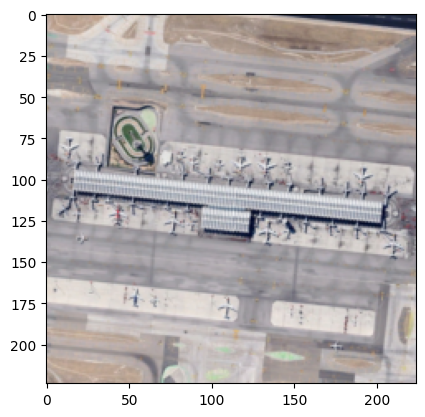

In [45]:
import matplotlib.pyplot as plt

plt.imshow(image_1.permute(1,2,0))

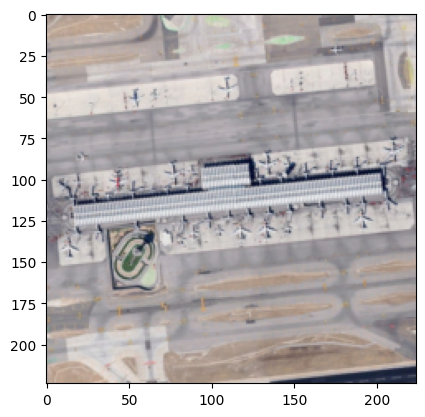

In [46]:
plt.imshow(image_2.permute(1,2,0))

In [27]:
import pandas as pd
df = pd.read_csv('AID_data.csv')
df

,Unnamed: 0,image,label_name,label
0,0,AID\Airport\airport_1.jpg,Airport,0
1,1,AID\Airport\airport_10.jpg,Airport,0
2,2,AID\Airport\airport_100.jpg,Airport,0
3,3,AID\Airport\airport_101.jpg,Airport,0
4,4,AID\Airport\airport_102.jpg,Airport,0
...,...,...,...,...
9995,9995,AID\Viaduct\viaduct_95.jpg,Viaduct,29
9996,9996,AID\Viaduct\viaduct_96.jpg,Viaduct,29
9997,9997,AID\Viaduct\viaduct_97.jpg,Viaduct,29
9998,9998,AID\Viaduct\viaduct_98.jpg,Viaduct,29


In [33]:
test = df.sample(frac = 0.2, replace = False).reset_index(drop = True).drop(columns=['Unnamed: 0'])
train = df[~df['image'].isin(test['image'].values)].reset_index(drop = True).drop(columns=['Unnamed: 0'])
train

,image,label_name,label
0,AID\Airport\airport_1.jpg,Airport,0
1,AID\Airport\airport_101.jpg,Airport,0
2,AID\Airport\airport_102.jpg,Airport,0
3,AID\Airport\airport_103.jpg,Airport,0
4,AID\Airport\airport_105.jpg,Airport,0
...,...,...,...
7995,AID\Viaduct\viaduct_94.jpg,Viaduct,29
7996,AID\Viaduct\viaduct_95.jpg,Viaduct,29
7997,AID\Viaduct\viaduct_97.jpg,Viaduct,29
7998,AID\Viaduct\viaduct_98.jpg,Viaduct,29


In [35]:
train.to_csv('AID_data_train.csv', index = False)
test.to_csv('AID_data_val.csv', index = False)


In [3]:
from model import LORAModel
import torch
model = LORAModel()

self_attn_1, o1, self_attn_2, o2 = model(torch.randn(2,3,224,224),torch.randn(2,3,224,224))

In [4]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"trainable parameters: {num_params/2**20:.3f}M")
num_params = sum(p.numel() for p in model.parameters())
print(f"total parameters: {num_params/2**20:.3f}M")

trainable parameters: 0.116M
total parameters: 20.778M


In [44]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"trainable parameters: {num_params/2**20:.3f}M")
num_params = sum(p.numel() for p in model.parameters())
print(f"total parameters: {num_params/2**20:.3f}M")

trainable parameters: 0.081M
total parameters: 20.743M


In [2]:
from lora import LoRA_ViT_timm_mod
import timm
import torch
model = LoRA_ViT_timm_mod(timm.create_model('vit_small_patch16_224',num_classes = 0, pretrained=True), r=4)
model(torch.randn(1,3,224,224));

In [13]:
qkv = torch.randn(1,197,1152)
dim = 384

In [33]:
import pandas as pd 

df = pd.read_csv('AID_data_val.csv')

frames = []

for i in range(len(df)):
    row = df.iloc[i]
    df_pos = df[df['label']==row['label']]
    df_neg = df[df['label']!=row['label']]
    pos = df_pos.sample(n = 1).reset_index(drop=True).iloc[0]
    neg = df_neg.sample(n = 1).reset_index(drop=True).iloc[0]
    frames.append(pd.DataFrame({
        'image':row['image'],
        'label':row['label'],
        'label_name':row['label_name'],
        'image_pos':pos['image'],
        'label_pos':pos['label'],
        'label_name_pos':pos['label_name'],
        'image_neg':neg['image'],
        'label_neg':neg['label'],
        'label_name_neg':neg['label_name'],
    },index = [0]))

In [34]:
pd.concat(frames).reset_index(drop = True).to_csv('AID_data_triplet_val.csv', index = False)

In [37]:
import pandas as pd
df1 = pd.read_csv('AID_data_train.csv')
df2 = pd.read_csv('AID_data_triplet.csv')

pd.merge(df1, df2, how='outer',on='image').rename(columns={'label_name_x':'label_name', 'label_x':'label'}).drop(columns=['label_y', 'label_name_y'])

,image,label_name,label,image_pos,label_pos,label_name_pos,image_neg,label_neg,label_name_neg
0,AID\Airport\airport_1.jpg,Airport,0,AID\Airport\airport_277.jpg,0,Airport,AID\Square\square_220.jpg,26,Square
1,AID\Airport\airport_101.jpg,Airport,0,AID\Airport\airport_347.jpg,0,Airport,AID\Commercial\commercial_201.jpg,7,Commercial
2,AID\Airport\airport_102.jpg,Airport,0,AID\Airport\airport_32.jpg,0,Airport,AID\Park\park_173.jpg,16,Park
3,AID\Airport\airport_103.jpg,Airport,0,AID\Airport\airport_351.jpg,0,Airport,AID\Beach\beach_17.jpg,3,Beach
4,AID\Airport\airport_105.jpg,Airport,0,AID\Airport\airport_194.jpg,0,Airport,AID\Square\square_16.jpg,26,Square
...,...,...,...,...,...,...,...,...,...
7995,AID\Viaduct\viaduct_94.jpg,Viaduct,29,AID\Viaduct\viaduct_262.jpg,29,Viaduct,AID\Beach\beach_397.jpg,3,Beach
7996,AID\Viaduct\viaduct_95.jpg,Viaduct,29,AID\Viaduct\viaduct_7.jpg,29,Viaduct,AID\StorageTanks\storagetanks_268.jpg,28,StorageTanks
7997,AID\Viaduct\viaduct_97.jpg,Viaduct,29,AID\Viaduct\viaduct_383.jpg,29,Viaduct,AID\Resort\resort_40.jpg,22,Resort
7998,AID\Viaduct\viaduct_98.jpg,Viaduct,29,AID\Viaduct\viaduct_324.jpg,29,Viaduct,AID\Farmland\farmland_89.jpg,10,Farmland


In [38]:
from torch import nn
import torch

loss_fn = nn.TripletMarginLoss()

loss_fn(torch.randn(32,384),torch.randn(32,384),torch.randn(32,384))

tensor(1.1240)